## DETECTION AND ATTRIBUTION

This notebook is an attempt to create a model to do a "Detection and Attribution" study out of our findings. 

It builds on the correlation of climatic indices (SAM, ENSO, IOD, Polar vortex) to the mooring data, outlining a possible approach using a multiple linear regression model. This approach assumes a linear relationship between the climatic indices and the upwelling phenomenon - which might not be true and needs a bit of research on still.

### STEPS THAT SHOULD BE DONE BEFORE GETTING HERE: 

STEP 1: Data Preparation
1. Collect historical data for the South Australian upwelling (mooring data from IMOS) and the climatic indices (SAM, ENSO, IOD, Polar vortex, etc) for the same time period. 
2. Preprocess the data to handle missing values, outliers, and inconsistencies.
- relevant notebooks: 


Step 2: Correlation Analysis
1. Calculate Pearson correlation coefficients between the upwelling data and each climatic index. This initial analysis will give you a sense of the relationships.
- relevant notebooks: 

### STEPS STILL TO DO: 
Step 1: Multiple Linear Regression Model
1. Organize your data into a dataset with columns for the upwelling and the climatic indices.
2. Divide the dataset into training and testing sets for model validation.

Step 2: Model Building and training.
1. Build the multiple linear regression model 
2. Train the model using the training dataset. The model will learn the relationships between the upwelling and the climatic indices.

Step 3: Model Evaluation
1. Evaluate the model's performance using the testing dataset. Metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared can assess how well the model fits the data.

Step 4: Interpretation
1. Interpret the model coefficients. A positive coefficient indicates a positive correlation between the climatic index and the upwelling, while a negative coefficient indicates a negative correlation.

Step 5: Scenario Analysis and Visualization
1. Simulate different scenarios by altering the values of the climatic indices in the model.
2. Plot the simulated upwelling values against the original observed values for visual comparison.

Step 8: Sensitivity Analysis
1. Perform sensitivity analysis by introducing variations in the climatic indices and observing their effects on the simulated upwelling.

Step 9: Discussion and Implications
1. Discuss the results of your model in the context of the South Australian upwelling phenomenon and the role of the climatic indices in its suppression.
2. Highlight any interesting findings, interactions between indices, and potential implications for the marine ecosystem.

Step 10: other models. 
1. You might need to explore more advanced modeling techniques, such as nonlinear regression, machine learning algorithms, or time series analysis, depending on the complexity of the relationships and the data.

In [1]:
# Import necessary libraries
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
sys.path.insert(0, "../sa_upwelling/")
from utils import create_modelling_data, create_regression_model

sc = StandardScaler()

### 1. Data Loading

In [2]:
temp_series = glob("../Datasets/*TEMP*.csv")
get_mooring_id = lambda s: s.split("/")[-1].split("_")[0]

Mean Squared Error: 1.1268762548281133
R-squared: 0.3975719801278632


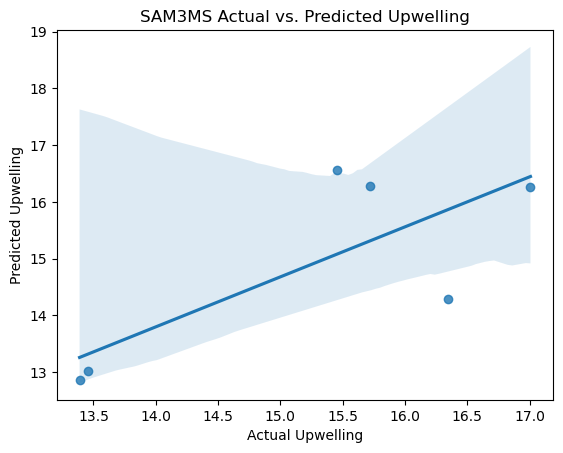

Mean Squared Error: 1.3481673447724614
R-squared: 0.2792697685413257


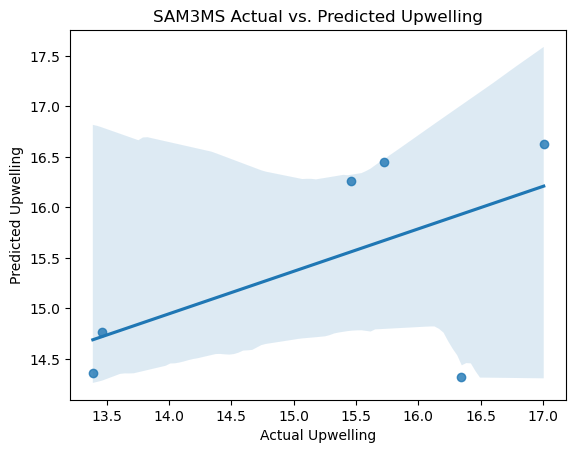

Mean Squared Error: 2.413155278100319
R-squared: 0.01597463175767655


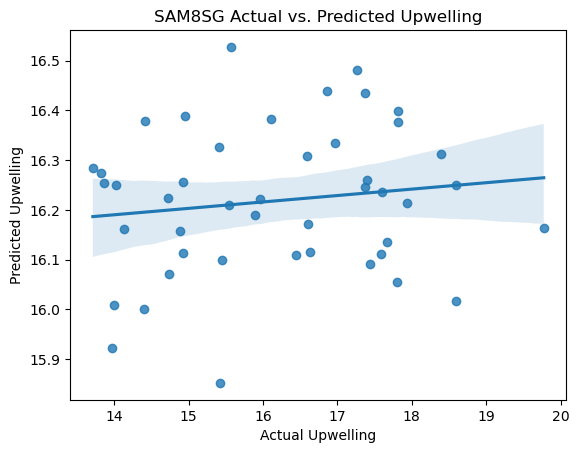

Mean Squared Error: 2.354622865115561
R-squared: 0.039842710104785684


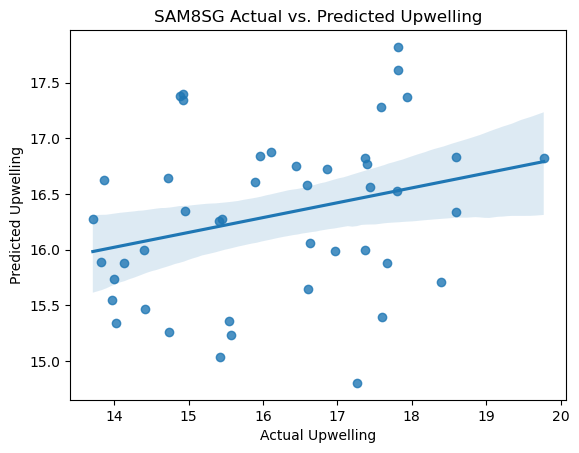

Mean Squared Error: 0.6994171631118669
R-squared: 0.09095330521513323


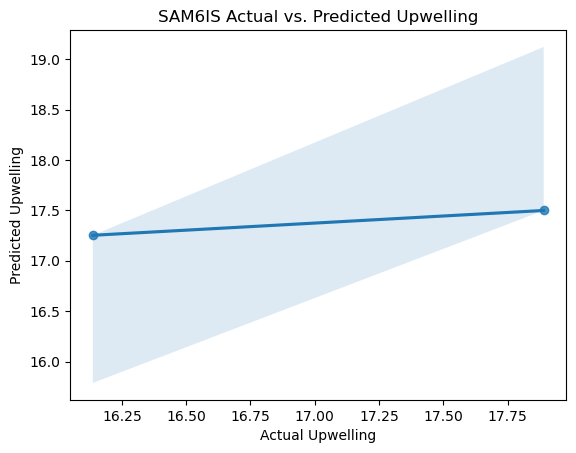

Mean Squared Error: 0.7265741013433218
R-squared: 0.05565688093245891


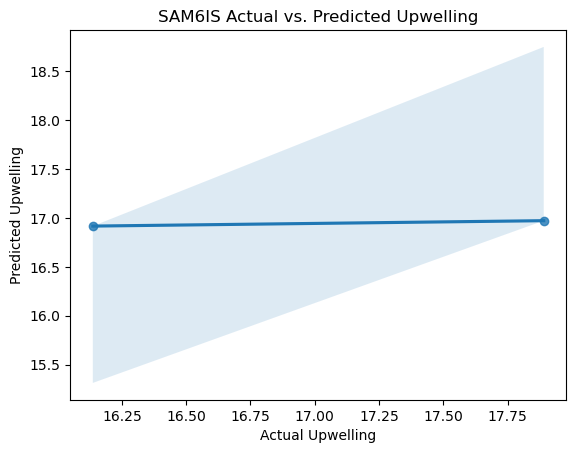

Mean Squared Error: 3.498519088190971
R-squared: -0.4164585031985977


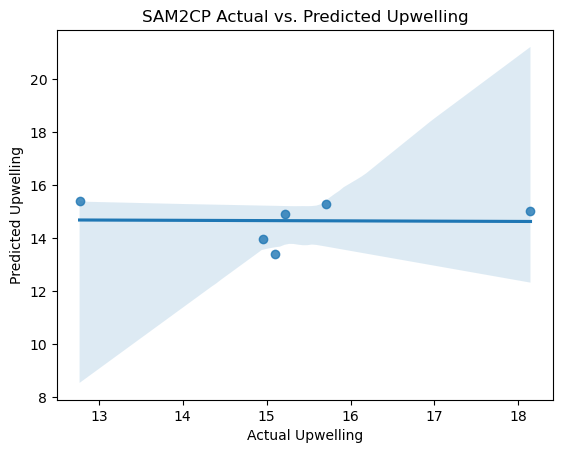

Mean Squared Error: 1.7589145476036672
R-squared: 0.2878616910330457


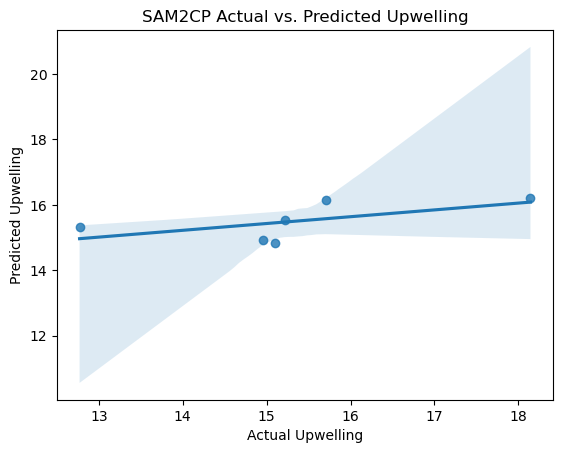

Mean Squared Error: 2.9778976729829507
R-squared: 0.01202105605618764


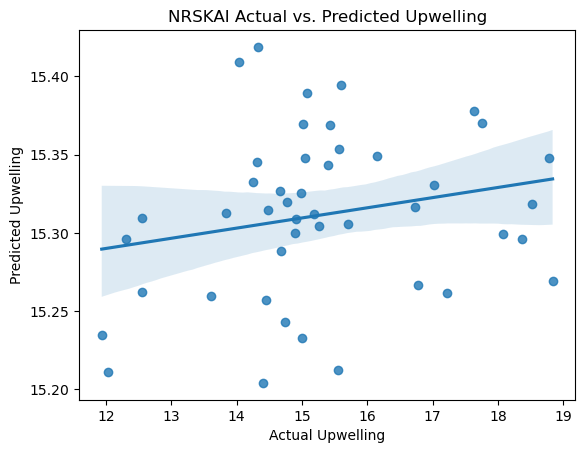

Mean Squared Error: 2.9374684596845024
R-squared: 0.02543428103751111


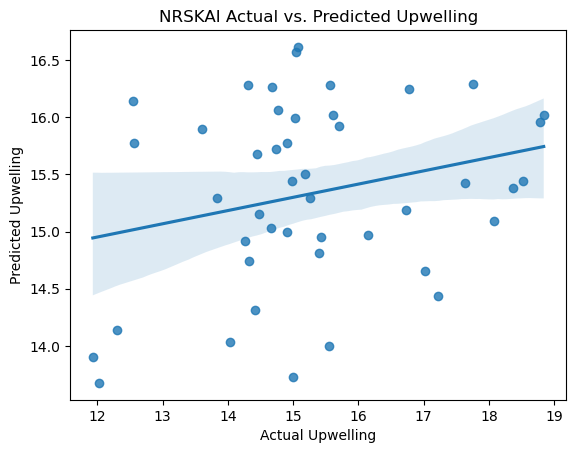

Mean Squared Error: 0.02613254838578964
R-squared: 0.39604492064929664


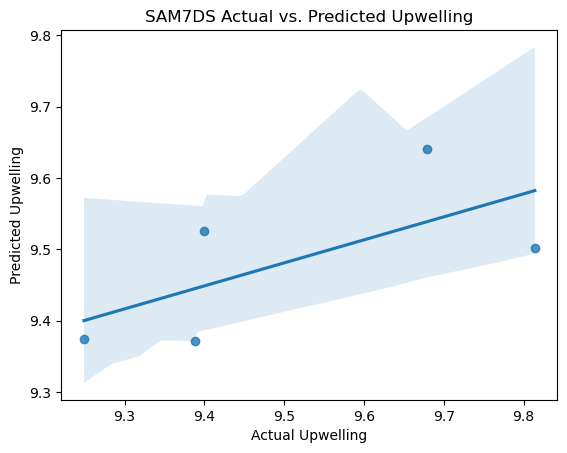

Mean Squared Error: 0.029048832939896414
R-squared: 0.3286460262405695


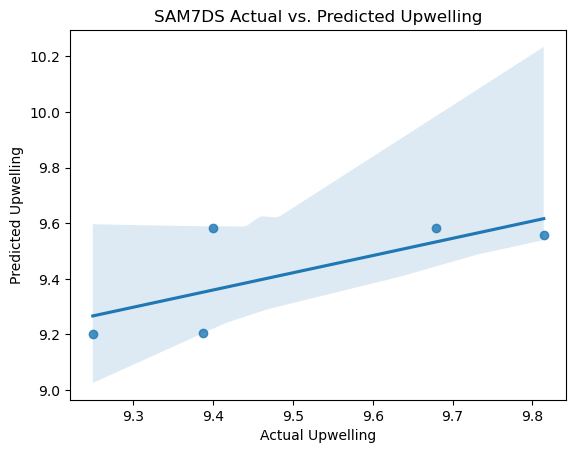

Mean Squared Error: 1.70047590969943
R-squared: -0.061773850995261226


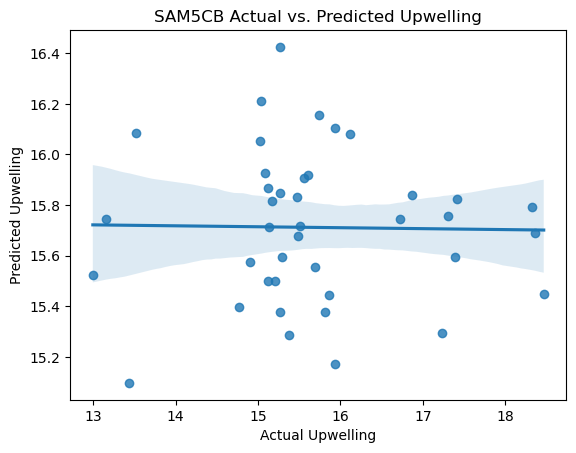

Mean Squared Error: 1.3518829362335694
R-squared: 0.15588692370642676


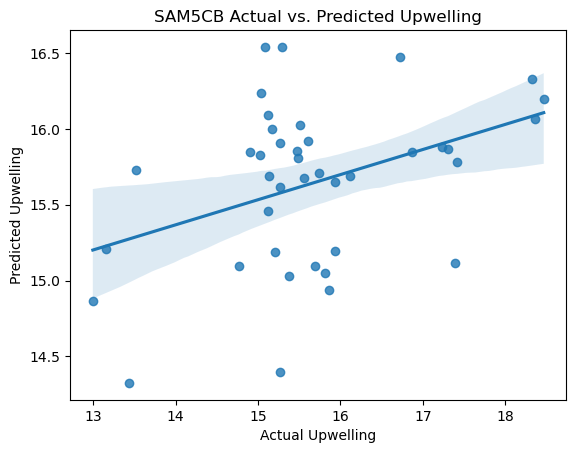

In [3]:
# Upwelling data
for csv in temp_series:
    mooring_id = get_mooring_id(csv)
    data, X, y = create_modelling_data(csv)
    create_regression_model(X, y, mooring_id=mooring_id)
    create_regression_model(X, y, model=RandomForestRegressor, mooring_id=mooring_id)